<a href="https://colab.research.google.com/github/cjakuc/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] If you haven't completed assignment #1, please do so first.
- [x] Continue to clean and explore your data. Make exploratory visualizations.
- [x] Fit a model. Does it beat your baseline? 
- [x] Try xgboost.
- [x] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

# Import data

In [0]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
!pip install category_encoders==2.*
!pip install eli5

In [0]:
# Import data
df = pd.read_csv('https://github.com/cjakuc/DS-Unit2_Build-Week/blob/master/Data/BuildWeek2FinalData.csv?raw=true',
                 infer_datetime_format=True,
                 index_col=0)

# Train, val, test split

In [0]:
# Create train, val, and test sets
train = df[df['year']<2014]
val = df[df['year']==2014]
test = df[df['year']==2015]

# Exploratory visualizations

# Random forest model

In [5]:
# Get baseline MAE
target = 'MW'
guess_train = train[target].mean()
guess_val = val[target].mean()
baseline_train_mae = (guess_train - train[target]).abs().mean()
baseline_val_mae = (guess_val - val[target]).abs().mean()
print(f'Baseline Train MAE: {baseline_train_mae:,.2f}MW\n')
print(f'Baseline Validation MAE: {baseline_val_mae:,.2f}MW')

Baseline Train MAE: 317.08MW

Baseline Validation MAE: 304.69MW


In [0]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

# Pipe, build, fit, validate, and visualize the model
def full_pipe(train,val):
  """Define a function that selects features, pipes, encodes,
     and fits a RandomForestRegressor model to a log transformed target
     Returns the pipeline and features"""

  # Select target
  target = 'MW'
  # Drop target from features
  features = train.drop(columns=[target,'HourlySeaLevelPressure']).columns.tolist()

  # Arrange X features matrix & y target vector
  X_train = train[features]
  y_train = train[target]
  X_val = val[features]
  y_val = val[target]

  # Pipeline
  pipeline = make_pipeline(
      ce.OrdinalEncoder(),
      TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=100,
                                                                 random_state=42,
                                                                 n_jobs=-1),
                                 func=np.log1p,
                                 inverse_func=np.expm1)
  )

  pipeline.fit(X_train, y_train)
  print('Train MAE', mean_absolute_error(y_train,pipeline.predict(X_train)))
  print('Validation MAE', mean_absolute_error(y_val,pipeline.predict(X_val)))
  print(f'Train R^2 Score: {pipeline.score(X_train,y_train)}')
  print(f'Validation R^2 Score: {pipeline.score(X_val,y_val)}\n')

  # Plot the residuals
  errors = (val[target] - pipeline.predict(val[features]))
  sns.scatterplot(x=val[target],y=errors,alpha=0.1)
  # Add a horizontal line at residuals = 0
  plt.hlines(y=0,xmin=1000,xmax=3200,color='red');
  plt.title('Residuals vs Validation Target')
  plt.ylabel('Residuals (MW)')
  plt.xlabel('Validation Target (MW)')
  plt.show()

  # Plot the feature importances
  %matplotlib inline
  model = pipeline.named_steps['transformedtargetregressor'] #Pull out transregressor
  model = model.regressor_ #Pull out random forest regressor
  encoder = pipeline.named_steps['ordinalencoder'] #Pull out encoder
  encoded_columns = encoder.transform(val[features]).columns #Pull out encoded columns
  importances = pd.Series(model.feature_importances_, encoded_columns) #Pull out coefficients
  importances.sort_values().plot.barh()
  plt.title('Model Feature Importances')
  plt.xlabel('Values')
  plt.ylabel('Feature Importances')
  plt.show();

  # Plot the residuals vs the actual
  import matplotlib.lines as mlines
  blue_line = mlines.Line2D([],[],color='#2077B4',
                            linewidth=3)
  orange_line = mlines.Line2D([],[],color='#FC7F0F',
                              linewidth=3)
  sns.lineplot(x=val['date'],y=val['MW'])
  sns.lineplot(x=val['date'],y=pipeline.predict(val[features]))
  plt.title('Actual vs Predicted Values')
  # Create the legend
  plt.legend(handles=[blue_line,
                      orange_line],
             labels=['Actual',
                     'Predicted']);

  return pipeline, features

Train MAE 28.310186042373537
Validation MAE 151.00466710128256
Train R^2 Score: 0.9900712595539575
Validation R^2 Score: 0.7637359319025206



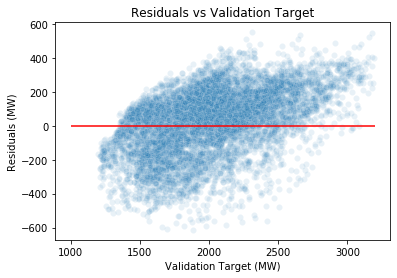

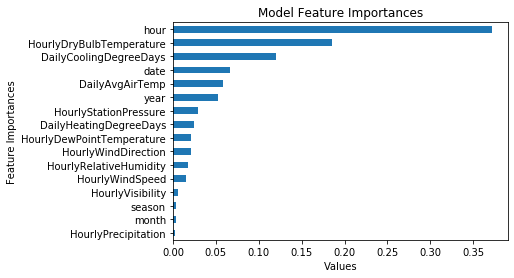

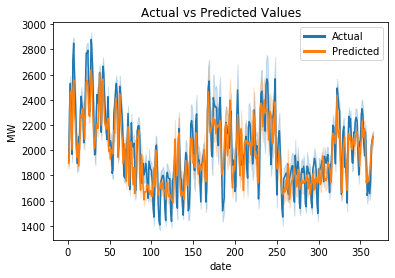

In [40]:
pipeline, features = full_pipe(train,val)

# Try XGBoost

In [0]:
# Select target
target = 'MW'
# Drop target from features
features = train.drop(columns=[target,'HourlySeaLevelPressure']).columns.tolist()

# Arrange X features matrix & y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [16]:
from xgboost import XGBRegressor

# Pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[23:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['season'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'season',
                                          'data_type': dtype('O'),
                                          'mapping': winter    1
spring    2
summer    3
fall      4
NaN      -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=-1,
                      

In [17]:
from sklearn.metrics import mean_absolute_error
y_pred = pipeline.predict(X_val)
print(f'Validation MAE: {mean_absolute_error(y_val,y_pred)}')

Validation MAE: 148.1671244024686


In [36]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBRegressor(
    n_estimators=1000, # <= 1000 trees, depend on early stopping
    max_depth=7,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.5, # try higher learning rate
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='mae', 
          early_stopping_rounds=50) # Stop if the score hasn't improved in 50 rounds

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:58:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:1027.52	validation_1-mae:1013.87
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:514.956	validation_1-mae:507.56
[2]	validation_0-mae:276.98	validation_1-mae:282.824
[3]	validation_0-mae:188.475	validation_1-mae:201.419
[4]	validation_0-mae:155.749	validation_1-mae:169.407
[5]	validation_0-mae:142.522	validation_1-mae:158.084
[6]	validation_0-mae:135.455	validation_1-mae:152.218
[7]	validation_0-mae:131.997	validation_1-mae:149.336
[8]	validation_0-mae:130.071	validation_1-mae:147.4
[9]	validation_0-mae:126.726	validation_1-mae:148.076
[10]	validation_0-mae:123.357	validation_1-mae:149.184
[11]	validation_0-mae:122.153	validation_1-mae:148.986
[12]	validation_0-mae:121.398	validation_1-mae:148.705
[13]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

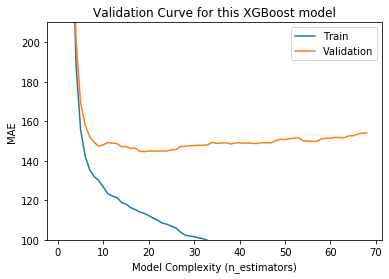

In [26]:
results = model.evals_result()
train_error = results['validation_0']['mae']
val_error = results['validation_1']['mae']
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('MAE')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
plt.ylim((100, 210)) # Zoom in
plt.legend();

# Try permutations importance

In [31]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='neg_mean_absolute_error', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_encoded, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.5,
                                             max_delta_step=0, max_depth=7,
                                             min_child_weight=1, missing=None,
                                             n_estimators=1000, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:linear',
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                     

In [52]:
# Display permutation importances
feature_names = X_val.columns.tolist()
x = eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)
x

Weight,Feature
125.8724 ± 2.5361,hour
71.9275 ± 1.0755,HourlyDryBulbTemperature
67.9811 ± 3.4431,DailyAvgAirTemp
33.2233 ± 2.3344,date
15.3269 ± 0.6308,HourlyDewPointTemperature
3.7270 ± 0.7067,season
2.0723 ± 0.5496,HourlyStationPressure
1.2207 ± 0.3270,HourlyRelativeHumidity
1.2109 ± 0.2523,month
1.0656 ± 0.3207,HourlyWindDirection


# Try log transformation, XGBoost, permutation importance in a full_pipe custom function

In [0]:
# Build, fit, validate, and visualize the model
def full_model(train,val):
  """Define a function that selects features, encodes,
     and fits a XGBRegressor model
     Returns the model and features"""

  # Select target
  target = 'MW'
  # Drop target from features
  features = train.drop(columns=[target,'HourlySeaLevelPressure']).columns.tolist()

  # Arrange X features matrix & y target vector
  X_train = train[features]
  y_train = train[target]
  X_val = val[features]
  y_val = val[target]

  # Encode
  encoder = ce.OrdinalEncoder()
  X_train_encoded = encoder.fit_transform(X_train)
  X_val_encoded = encoder.transform(X_val)

  # Build model
  model = XGBRegressor(n_estimators=1000,
                       max_depth=6,
                       random_state=42,
                       learning_rate=0.5,
                       n_jobs=-1,
                       verbosity=0)
  # Fit model
  eval_set = [(X_train_encoded, y_train), 
              (X_val_encoded, y_val)]

  model.fit(X_train_encoded, y_train, 
            eval_set=eval_set, 
            eval_metric='mae', 
            early_stopping_rounds=50,
            verbose=False)
  
  # Print scores
  print(f'XGB best iterations: {model.best_iteration}')
  print('Train MAE', mean_absolute_error(y_train,model.predict(X_train_encoded)))
  print('Validation MAE', mean_absolute_error(y_val,model.predict(X_val_encoded)))
  print(f'Train R^2 Score: {model.score(X_train_encoded,y_train)}')
  print(f'Validation R^2 Score: {model.score(X_val_encoded,y_val)}\n')

  # Plot the residuals
  errors = (y_val - model.predict(X_val_encoded))
  sns.scatterplot(x=y_val,y=errors,alpha=0.1)
  # Add a horizontal line at residuals = 0
  plt.hlines(y=0,xmin=1000,xmax=3200,color='red');
  plt.title('Residuals vs Validation Target')
  plt.ylabel('Residuals (MW)')
  plt.xlabel('Validation Target (MW)')
  plt.show()


  # Plot the residuals vs the actual
  import matplotlib.lines as mlines
  blue_line = mlines.Line2D([],[],color='#2077B4',
                            linewidth=3)
  orange_line = mlines.Line2D([],[],color='#FC7F0F',
                              linewidth=3)
  sns.lineplot(x=val['date'],y=val['MW'])
  sns.lineplot(x=val['date'],y=model.predict(X_val_encoded))
  plt.title('Actual vs Predicted Values')
  # Create the legend
  plt.legend(handles=[blue_line,
                      orange_line],
             labels=['Actual',
                     'Predicted']);

  # Show the permutation importances
  permuter = PermutationImportance(
      model, 
      scoring='neg_mean_absolute_error', 
      n_iter=5, 
      random_state=42
  )
  permuter.fit(X_val_encoded, y_val)
  feature_names = X_val_encoded.columns.tolist()
  permutation_importances = eli5.show_weights(
      permuter, 
      top=None, # No limit: show permutation importances for all features
      feature_names=feature_names # must be a list
  )
  permutation_importances

  return model, features, permutation_importances

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGB best iterations: 24
Train MAE 117.79122222196892
Validation MAE 144.1914803840254
Train R^2 Score: 0.8619993205820009
Validation R^2 Score: 0.7800151247505819



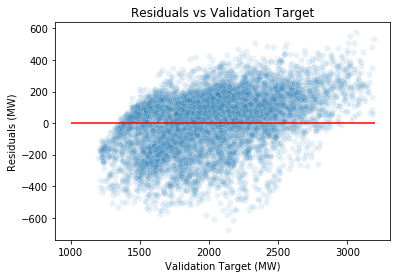

Weight,Feature
128.9850 ± 1.7047,hour
67.6405 ± 0.9634,HourlyDryBulbTemperature
60.0399 ± 2.5513,DailyAvgAirTemp
25.9112 ± 2.3351,date
10.3703 ± 0.4582,HourlyDewPointTemperature
3.9661 ± 0.5442,season
2.6951 ± 0.5358,HourlyWindDirection
2.1451 ± 0.4435,HourlyStationPressure
1.7141 ± 0.1279,HourlyRelativeHumidity
1.1099 ± 0.2434,HourlyPrecipitation


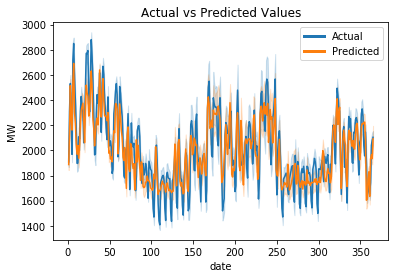

In [69]:
model, features, permutation_importances = full_model(train,val)
permutation_importances

# Change the features to make it more realistic and engineer some lagged features

In [0]:
# Lagged variables add NaN values which don't allow for getting the permutation importance
# Unsure how to handle this
def wrangle(X):
  """Wrangle train, validate, and test in the same way"""

  X = X.copy()

  # Add lagged variables
  X['DailyAvgAirTemp_lag1'] = X['DailyAvgAirTemp'].shift()
  X['DailyHeatingDegreeDays_lag1'] = X['DailyHeatingDegreeDays'].shift()
  X['DailyCoolingDegreeDays_lag1'] = X['DailyCoolingDegreeDays'].shift()
  X['DailyHeatingDegreeDays_lag24'] = X['DailyHeatingDegreeDays'].shift(24)
  X['DailyCoolingDegreeDays_lag24'] = X['DailyCoolingDegreeDays'].shift(24)
  X['DailyHeatingDegreeDays_lag365'] = X['DailyHeatingDegreeDays'].shift(365)
  X['DailyCoolingDegreeDays_lag365'] = X['DailyCoolingDegreeDays'].shift(365)
  X['MW_lag1'] = X['MW'].shift()
  X['MW_lag24'] = X['MW'].shift(24)
  X['MW_lag365'] = X['MW'].shift(365)

  # Drop unattainable info
  X = X.drop(columns=['DailyAvgAirTemp',
                      'DailyHeatingDegreeDays',
                      'DailyCoolingDegreeDays'])

  return X

# Wrangle train, val, and test
df_wrangled = wrangle(df)
train_wrangled = df_wrangled[df_wrangled['year']<2014]
val_wrangled = df_wrangled[df_wrangled['year']==2014]
test_wrangled = df_wrangled[df_wrangled['year']==2015]

# Use the full_model function on the wrangled data

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGB best iterations: 218
Train MAE 12.54840406613685
Validation MAE 18.528328255431294
Train R^2 Score: 0.9982524413598107
Validation R^2 Score: 0.995639100128557



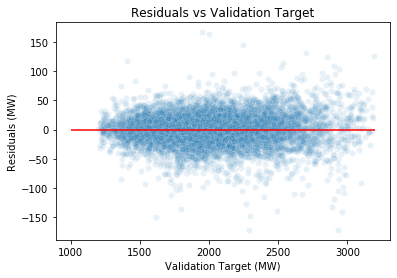

Weight,Feature
394.3762 ± 3.8062,MW_lag1
66.5403 ± 0.2895,hour
16.8519 ± 0.4480,HourlyDryBulbTemperature
5.7484 ± 0.2765,date
4.2983 ± 0.1305,DailyHeatingDegreeDays_lag24
3.2852 ± 0.1167,DailyAvgAirTemp_lag1
2.1831 ± 0.1460,HourlyDewPointTemperature
2.0806 ± 0.2513,MW_lag24
1.4313 ± 0.0936,DailyCoolingDegreeDays_lag24
1.2377 ± 0.1726,MW_lag365


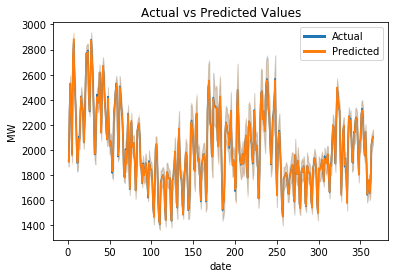

In [79]:
model, features, permutation_importances = full_model(train_wrangled,
                                                      val_wrangled)
permutation_importances

# TODO for the future:

Feature Engineering
- Remove the hourly and daily lags to simulate real forecasting
- Add weekend or non-weekend variable
- Add holidays variable for holidays with large affect on MW
- Add interactions between hours and seasons
- Drop year?

Modelling
- Try a LOESS regression
  - On a daily seasonality
  - On a seasonal seasonality